In [4]:
import requests
import pandas as pd
import ScraperExtend as scraper
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
import matplotlib.ticker as ticker 
import seaborn as sns

In [13]:
def get_commit_dataset(repo_name):
    gh_api = scraper.ScraperExtend(os.getenv("GITHUB_PERSONAL_ACCESS_TOKEN"))
    
    all_commits = gh_api.repo_commits(repo_name)
    commits_df = pd.DataFrame(all_commits)
    
    extracted_data = {
                    'sha': commits_df['sha'],
                    'author_name': commits_df['commit'].apply(lambda x: x.get('author', {}).get('name', 'Unknown')),
                    'committer_name': commits_df['commit'].apply(lambda x: x.get('committer', {}).get('name', 'Unknown')),
                    'author_date': commits_df['commit'].apply(lambda x: x.get('author', {}).get('date', 'Unknown')),
                    'committer_date': commits_df['commit'].apply(lambda x: x.get('committer', {}).get('date', 'Unknown')),
                    'commit_message': commits_df['commit'].apply(lambda x: x.get('message', 'Unknown')),
            }

    commit_info_df = pd.DataFrame(extracted_data)

    commit_info_df['author_date'] = pd.to_datetime(commit_info_df['author_date']).dt.strftime('%Y-%m-%d %H:%M:%S')
    commit_info_df['committer_date'] = pd.to_datetime(commit_info_df['committer_date']).dt.strftime('%Y-%m-%d %H:%M:%S')
    
    return commit_info_df


def get_issue_dataset(repo_name):
    gh_api = scraper.ScraperExtend(os.getenv("GITHUB_PERSONAL_ACCESS_TOKEN"))

    all_issues = gh_api.repo_issues(repo_name)
    issues_df = pd.DataFrame(all_issues)

    extracted_data = {
                    'issue_#': issues_df['number'],
                    'state': issues_df['state'],
                    'created_at': issues_df['created_at'],
                    'updated_at': issues_df['updated_at'],
                    'closed_at': issues_df['closed_at'],
                    'title': issues_df['title'],
                    'body': issues_df['body'],
                    'url': issues_df['html_url'],
                    'user': issues_df['user'].apply(lambda x: x.get('login', 'Unknown'))
            }

    issues_info_df = pd.DataFrame(extracted_data)
    issues_info_df['created_at'] = pd.to_datetime(issues_info_df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
    issues_info_df['updated_at'] = pd.to_datetime(issues_info_df['updated_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
    issues_info_df['closed_at'] = pd.to_datetime(issues_info_df['closed_at']).dt.strftime('%Y-%m-%d %H:%M:%S')

    return issues_info_df


def get_pr_dataset(repo_name):
	gh_api = scraper.ScraperExtend(os.getenv("GITHUB_PERSONAL_ACCESS_TOKEN"))
	
	all_prs = gh_api.repo_pulls(repo_name)
	prs_df = pd.DataFrame(all_prs)
	extracted_data = {
					'pr_#': prs_df['number'],
					'state': prs_df['state'],
					'created_at': prs_df['created_at'],
					'updated_at': prs_df['updated_at'],
					'closed_at': prs_df['closed_at'],
					'merged_at' : prs_df['merged_at'],
					'title': prs_df['title'],
					'body': prs_df['body'],
					'url': prs_df['html_url'],
					'issue_url' : prs_df['issue_url'],
					'merge_sha' : prs_df['merge_commit_sha'],
					'user': prs_df['user'].apply(lambda x: x.get('login', 'Unknown'))
			}

	prs_info_df = pd.DataFrame(extracted_data)
	prs_info_df['created_at'] = pd.to_datetime(prs_info_df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
	prs_info_df['updated_at'] = pd.to_datetime(prs_info_df['updated_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
	prs_info_df['closed_at'] = pd.to_datetime(prs_info_df['closed_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
	prs_info_df['merged_at'] = pd.to_datetime(prs_info_df['merged_at']).dt.strftime('%Y-%m-%d %H:%M:%S')

	return prs_info_df

**RDD Analysis:**


**List of Outcome Variables**
- PR Resolving Rate: # of PRs closed per month
- Review Time: Average time between PR Creation and merge
- Issue Resolving rate: # of issues resolved per month
- Issue Resolve Time: Average time taken to close issues
- Commit Frequency: # of commits per month

In [ ]:
repo_name = "tukaani-project/xz"
cutoff_date = pd.to_datetime("2022-10-28")  # Jia Tan's maintainer join date
treatment_end_date = pd.to_datetime("2024-03-28")  # Detection of attack
control_start_date = pd.to_datetime("2021-01-01")  # Start of control period

**Fetching Commit, PR, and Issues Dataset**

In [15]:
commit_info_df = get_commit_dataset(repo_name)
issues_info_df = get_issue_dataset(repo_name)
prs_info_df = get_pr_dataset(repo_name)


**RDD on Commit Frequency**
- Forcing Variable: Time (months/weeks since the forcing variable joined)
- Cutoff Date:      2022-10-28 (when Jia Tan got added to the Tukaani Organization)
- Treatment Group:  2022-10-28 to 2024-03-28
- Control Group:    2021-01-01 to 2022-10-27 
- Outcome Variable: Monthly/weekly commit frequency

**RDD Expectation:**
- If commit frequency significantly increased after the forcing variable joined, it suggests a potential correlation.
- A discontinuity (sharp increase/decrease in commits at the cutoff date) would indicate an effect.

In [ ]:
def commit_freq_rdd(commit_info_df, cutoff_date, control_start_date, treatment_end_date, mode):
	# calculate months and weeks since maintainer join date
	commit_info_df["committer_date"] = pd.to_datetime(commit_info_df["committer_date"], errors="coerce")
	commit_info_df = commit_info_df[(commit_info_df["committer_date"] >= control_start_date) & (commit_info_df["committer_date"] <= treatment_end_date)]

	if (mode == "monthly"):
		# calculate monthly and weekly commit frequency
		monthly_commits = commit_info_df.groupby("months_since_JT_joined").size().reset_index(name="commit_count")

		# label treatment and control group (1 for treatment, 0 for control)
		monthly_commits["treatment"] = (monthly_commits["months_since_JT_joined"] >= 0).astype(int)

		# calculate months and weeks since maintainer join date
		commit_info_df["months_since_JT_joined"] = ((commit_info_df["committer_date"] - cutoff_date) / pd.Timedelta(days=30)).astype(int)

		# monthly linear regression model
		month_X = monthly_commits[["months_since_JT_joined", "treatment"]]
		month_y = monthly_commits["commit_count"]

		monthly_linear_model = LinearRegression()
		monthly_linear_model.fit(month_X, month_y)

		# predict commit count for visualization
		monthly_commits["predicted_monthly_commit_count"] = monthly_linear_model.predict(month_X)
		monthly_commits.rename(columns={"commit_count": "monthly_commit_count","months_since_JT_joined": "months_since_forcing_variable"}, inplace=True)

		return monthly_commits


	
	elif (mode == "weekly"):
		weekly_commits = commit_info_df.groupby("weeks_since_JT_joined").size().reset_index(name="commit_count")
		weekly_commits["treatment"] = (weekly_commits["weeks_since_JT_joined"] >= 0).astype(int)
		commit_info_df["weeks_since_JT_joined"] = ((commit_info_df["committer_date"] - cutoff_date) / pd.Timedelta(days=7)).astype(int)

		# weekly linear regression model
		week_X = weekly_commits[["weeks_since_JT_joined", "treatment"]]

		week_y = weekly_commits["commit_count"]
		weekly_linear_model = LinearRegression()
		weekly_linear_model.fit(week_X, week_y)	

		weekly_commits["predicted_weekly_commit_count"] = weekly_linear_model.predict(week_X)
		weekly_commits.rename(columns={"commit_count": "weekly_commit_count", "weeks_since_JT_joined": "weeks_since_forcing_variable"}, inplace=True)

		return weekly_commits
	

def commit_freq_rdd_visulization(commit_freq_rdd_df, cutoff_date, control_start_date, treatment_end_date, mode):
	if (mode == "monthly"):
		commit_freq_rdd_df["date"] = cutoff_date + pd.to_timedelta(commit_freq_rdd_df["months_since_forcing_variable"] *30, unit="D")
		
		plt.figure(figsize=(10, 5))
		plt.scatter(commit_freq_rdd_df["date"], commit_freq_rdd_df["monthly_commit_count"], alpha=0.6)
		plt.plot(commit_freq_rdd_df["date"], commit_freq_rdd_df["predicted_monthly_commit_count"], color="red")

		plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b. %y"))  # Format as "Nov-23"
		plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show labels every 3 months

		plt.axvline(x=cutoff_date, color='r', linestyle='--', label=f"Forcing variable joined ({cutoff_date})")

		plt.xlabel("Date")
		plt.ylabel("Monthly Commit Count")
		plt.title("Monthly Commit Frequency Before & After Forcing Variable")
		plt.xticks(rotation=45)  # Rotate labels for readability
		plt.legend()
		plt.show()									
	
	elif (mode == "weekly"):
		commit_freq_rdd_df["date"] = cutoff_date + pd.to_timedelta(commit_freq_rdd_df["weeks_since_forcing_variable"] *7, unit="D")
		
		plt.figure(figsize=(10, 5))
		plt.scatter(commit_freq_rdd_df["date"], commit_freq_rdd_df["weekly_commit_count"], alpha=0.6)
		plt.plot(commit_freq_rdd_df["date"], commit_freq_rdd_df["predicted_weekly_commit_count"], color="red")

		plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b. %y"))  # Format as "Nov-23"
		plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show labels every 3 months

		plt.axvline(x=cutoff_date, color='r', linestyle='--', label=f"Forcing variable joined ({cutoff_date})")

		plt.xlabel("Date")
		plt.ylabel("Weekly Commit Count")
		plt.title("Weekly Commit Frequency Before & After Forcing Variable")
		plt.xticks(rotation=45)  # Rotate labels for readability
		plt.legend()
		plt.show()


/var/folders/4y/5xhzlmc1239f66mbkg4yyqrh0000gn/T/ipykernel_8840/3457409726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commit_info_df["committer_date"] = pd.to_datetime(commit_info_df["committer_date"], errors="coerce")


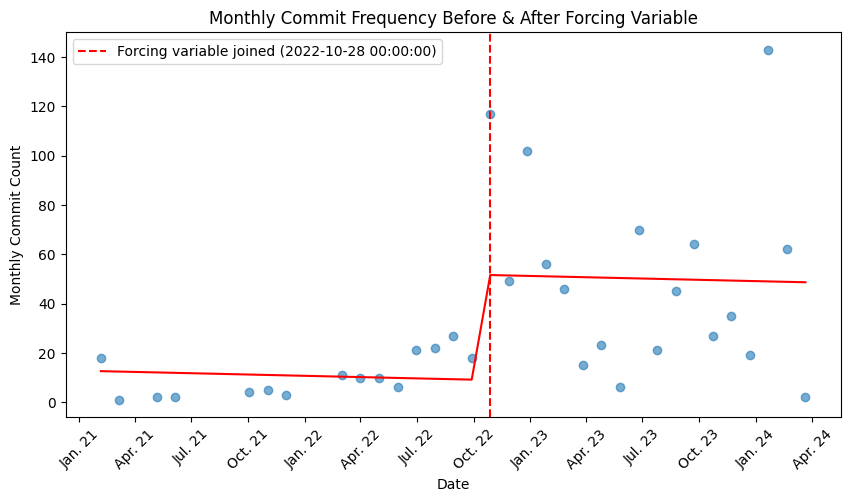

In [ ]:
monthly_commit_freq_rdd_df = commit_freq_rdd(commit_info_df, cutoff_date, control_start_date, treatment_end_date, "monthly")
commit_freq_rdd_visulization(monthly_commit_freq_rdd_df, cutoff_date, control_start_date, treatment_end_date, "monthly")




/var/folders/4y/5xhzlmc1239f66mbkg4yyqrh0000gn/T/ipykernel_8840/3457409726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commit_info_df["committer_date"] = pd.to_datetime(commit_info_df["committer_date"], errors="coerce")


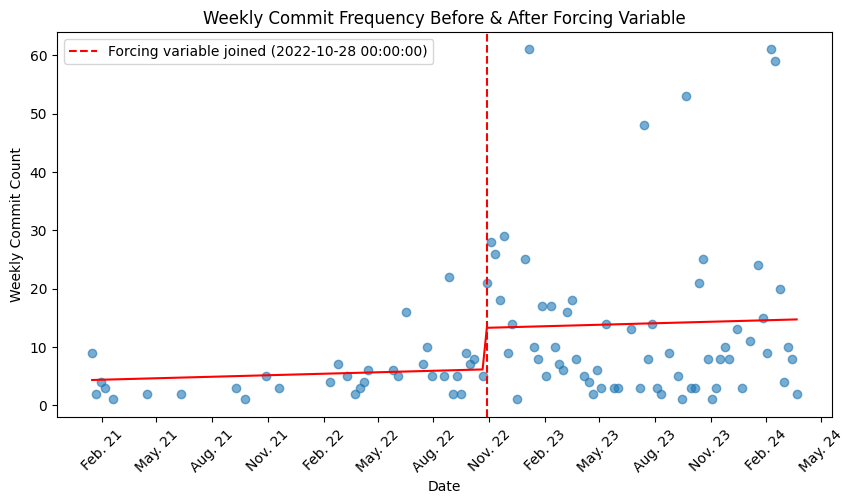

In [60]:
weekly_commit_freq_rdd_df = commit_freq_rdd(commit_info_df, cutoff_date, control_start_date, treatment_end_date, "weekly")
commit_freq_rdd_visulization(weekly_commit_freq_rdd_df, cutoff_date, control_start_date, treatment_end_date, "weekly")


**RDD on PR Resolve Frequency**
- Forcing Variable: Time (months since the forcing variable joined)
- Cutoff Date:      2022-10-28 (when Jia Tan got added to the Tukaani Organization)
- Treatment Group:  2022-10-28 to 2024-03-28
- Control Group:    2021-01-01 to 2022-10-27 (1.5 year before)
- Outcome Variable: Monthly PR resolve frequency

**RDD Expectation:**
- If PR resolve frequency significantly increased after the forcing variable joined, it suggests a potential correlation.
- A discontinuity would indicate an effect.

In [ ]:






prs_info_df["created_at"] = pd.to_datetime(prs_info_df["created_at"], errors="coerce")
prs_info_df["closed_at"] = pd.to_datetime(prs_info_df["closed_at"], errors="coerce")

prs_info_df = prs_info_df[(prs_info_df["state"] == "closed")]

prs_info_df = prs_info_df[
    (prs_info_df["created_at"] >= control_start_date) & 
    (prs_info_df["created_at"] <= treatment_end_date) &
    (prs_info_df["closed_at"] <= treatment_end_date)  # Ensure PRs were closed within the period
]

prs_info_df["months_since_JT_joined"] = (prs_info_df["closed_at"] - cutoff_date) / pd.Timedelta(days=30)
prs_info_df = prs_info_df.dropna(subset=["months_since_JT_joined"])  # Drop NaN rows
prs_info_df["months_since_JT_joined"] = prs_info_df["months_since_JT_joined"].astype(int)

prs_info_df["weeks_since_JT_joined"] = (prs_info_df["closed_at"] - cutoff_date) / pd.Timedelta(days=7)
prs_info_df = prs_info_df.dropna(subset=["weeks_since_JT_joined"])  # Drop NaN rows
prs_info_df["weeks_since_JT_joined"] = prs_info_df["weeks_since_JT_joined"].astype(int)

monthly_pr_closed = prs_info_df.groupby("months_since_JT_joined").size().reset_index(name="pr_closed_count")
monthly_pr_closed["treatment"] = (monthly_pr_closed["months_since_JT_joined"] >= 0).astype(int)

weekly_pr_closed = prs_info_df.groupby("weeks_since_JT_joined").size().reset_index(name="pr_closed_count")
weekly_pr_closed["treatment"] = (weekly_pr_closed["weeks_since_JT_joined"] >= 0).astype(int)

In [31]:
X = monthly_pr_closed[["months_since_JT_joined", "treatment"]]
y = monthly_pr_closed["pr_closed_count"]

linear_model = LinearRegression()
linear_model.fit(X, y)

monthly_pr_closed["predicted_pr_closed_count"] = linear_model.predict(X)


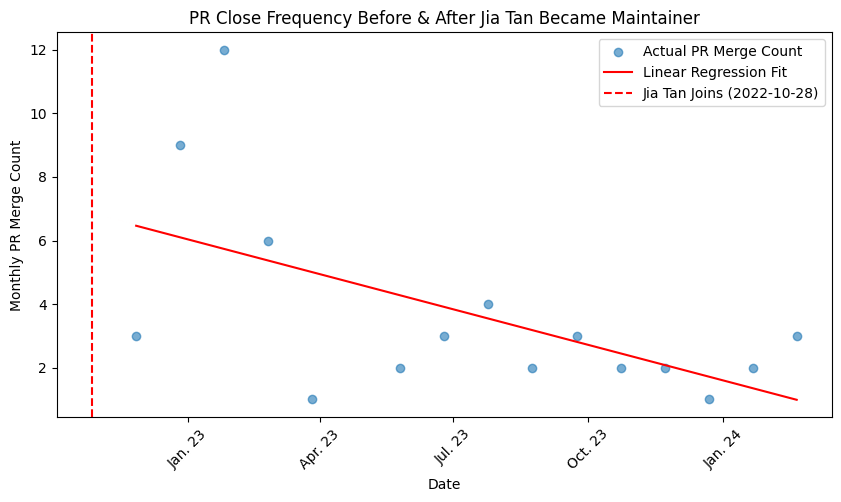

In [32]:
monthly_pr_closed["date"] = cutoff_date + pd.to_timedelta(monthly_pr_closed["months_since_JT_joined"] * 30, unit="D")

plt.figure(figsize=(10, 5))
plt.scatter(monthly_pr_closed["date"], monthly_pr_closed["pr_closed_count"], alpha=0.6, label="Actual PR Merge Count")
plt.plot(monthly_pr_closed["date"], monthly_pr_closed["predicted_pr_closed_count"], color="red", label="Linear Regression Fit")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b. %y"))  
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  

plt.axvline(x=cutoff_date, color='r', linestyle='--', label="Jia Tan Joins (2022-10-28)")

plt.xlabel("Date")
plt.ylabel("Monthly PR Merge Count")
plt.title("PR Close Frequency Before & After Jia Tan Became Maintainer")
plt.xticks(rotation=45) 
plt.legend()
plt.show()


In [33]:
# linear regression model
X = weekly_pr_closed[["weeks_since_JT_joined", "treatment"]]
y = weekly_pr_closed["pr_closed_count"]

linear_model = LinearRegression()
linear_model.fit(X, y)

# predict commit count for visualization
weekly_pr_closed["predicted_pr_closed_count"] = linear_model.predict(X)


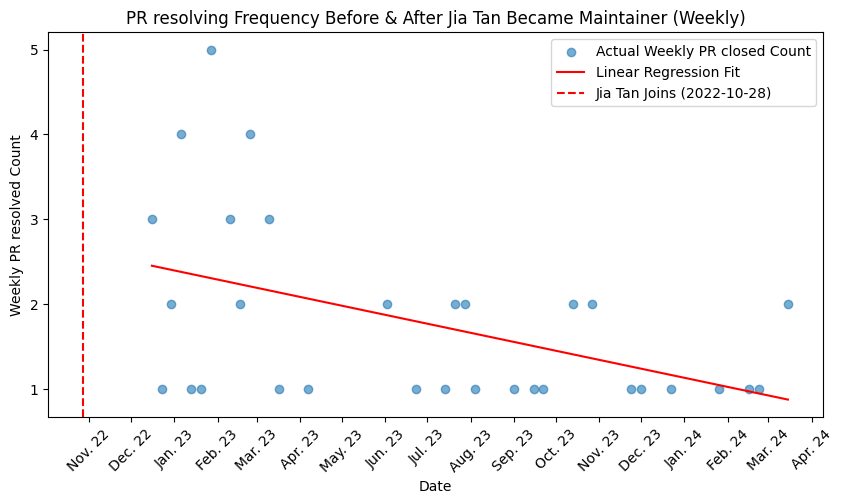

In [34]:
weekly_pr_closed["date"] = cutoff_date + pd.to_timedelta(weekly_pr_closed["weeks_since_JT_joined"] * 7, unit="D")

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(weekly_pr_closed["date"], weekly_pr_closed["pr_closed_count"], alpha=0.6, label="Actual Weekly PR closed Count")
plt.plot(weekly_pr_closed["date"], weekly_pr_closed["predicted_pr_closed_count"], color="red", label="Linear Regression Fit")

# Formatting the x-axis labels for weekly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b. %y"))  # Format as "Oct-22"
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Cutoff marker for when Jia Tan joined
plt.axvline(x=cutoff_date, color='r', linestyle='--', label="Jia Tan Joins (2022-10-28)")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Weekly PR resolved Count")
plt.title("PR resolving Frequency Before & After Jia Tan Became Maintainer (Weekly)")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.legend()
plt.show()


**RDD on Issue Resolve Frequency**
- Forcing Variable: Time (months/weeks since the forcing variable joined)
- Cutoff Date:      2022-10-28 (when Jia Tan got added to the Tukaani Organization)
- Treatment Group:  2022-10-28 to 2024-03-28
- Control Group:    2021-01-01 to 2022-10-27 (1.5 year before)
- Outcome Variable: Monthly Issue resolve frequency

**RDD Expectation:**
- If issue resolve frequency significantly increased after the forcing variable joined, it suggests a potential correlation.
- A discontinuity would indicate an effect.

In [35]:
issues_info_df["created_at"] = pd.to_datetime(issues_info_df["created_at"], errors="coerce")
issues_info_df["closed_at"] = pd.to_datetime(issues_info_df["closed_at"], errors="coerce")

issues_info_df = issues_info_df[(issues_info_df["state"] == "closed")]
issues_info_df = issues_info_df[
    (issues_info_df["created_at"] >= control_start_date) & 
    (issues_info_df["created_at"] <= treatment_end_date) &
    (issues_info_df["closed_at"] <= treatment_end_date)  # Ensure issues were closed within the period
]

issues_info_df["months_since_JT_joined"] = (issues_info_df["created_at"] - cutoff_date) / pd.Timedelta(days=30)
issues_info_df["weeks_since_JT_joined"] = (issues_info_df["created_at"] - cutoff_date) / pd.Timedelta(days=7)

issues_info_df = issues_info_df.dropna(subset=["months_since_JT_joined"])
issues_info_df = issues_info_df.dropna(subset=["weeks_since_JT_joined"])

issues_info_df["months_since_JT_joined"] = issues_info_df["months_since_JT_joined"].astype(int)
issues_info_df["weeks_since_JT_joined"] = issues_info_df["weeks_since_JT_joined"].astype(int)

monthly_issues_closed = issues_info_df.groupby("months_since_JT_joined").size().reset_index(name="issue_closed_count")
weekly_issues_closed = issues_info_df.groupby("weeks_since_JT_joined").size().reset_index(name="issue_closed_count")

monthly_issues_closed["treatment"] = (monthly_issues_closed["months_since_JT_joined"] >= 0).astype(int)
weekly_issues_closed["treatment"] = (weekly_issues_closed["weeks_since_JT_joined"] >= 0).astype(int)

In [36]:
X = monthly_issues_closed[["months_since_JT_joined", "treatment"]]
y = monthly_issues_closed["issue_closed_count"]

linear_model = LinearRegression()
linear_model.fit(X, y)

monthly_issues_closed["predicted_issue_closed_count"] = linear_model.predict(X)


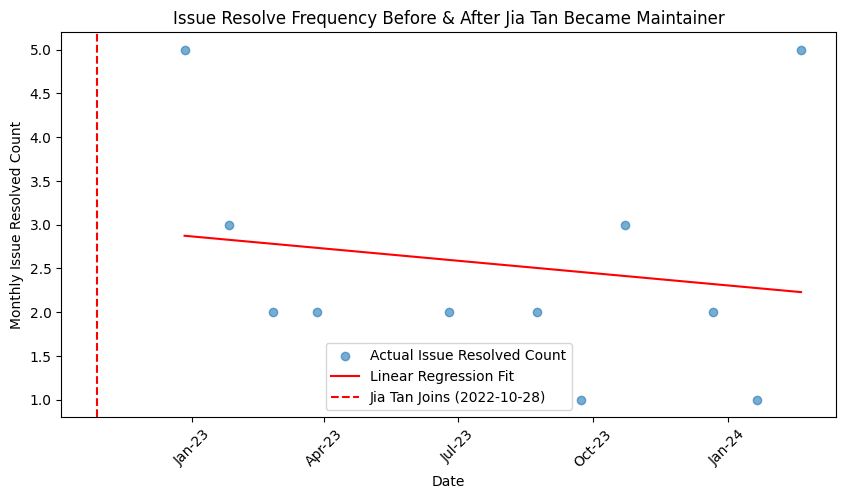

In [37]:
monthly_issues_closed["date"] = cutoff_date + pd.to_timedelta(monthly_issues_closed["months_since_JT_joined"] * 30, unit="D")

plt.figure(figsize=(10, 5))
plt.scatter(monthly_issues_closed["date"], monthly_issues_closed["issue_closed_count"], alpha=0.6, label="Actual Issue Resolved Count")
plt.plot(monthly_issues_closed["date"], monthly_issues_closed["predicted_issue_closed_count"], color="red", label="Linear Regression Fit")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%y")) 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 

plt.axvline(x=cutoff_date, color='r', linestyle='--', label="Jia Tan Joins (2022-10-28)")

plt.xlabel("Date")
plt.ylabel("Monthly Issue Resolved Count")
plt.title("Issue Resolve Frequency Before & After Jia Tan Became Maintainer")
plt.xticks(rotation=45)  
plt.legend()
plt.show()


Issues

In [38]:
# linear regression model
X = weekly_issues_closed[["weeks_since_JT_joined", "treatment"]]
y = weekly_issues_closed["issue_closed_count"]

linear_model = LinearRegression()
linear_model.fit(X, y)

# predict commit count for visualization
weekly_issues_closed["predicted_issue_closed_count"] = linear_model.predict(X)


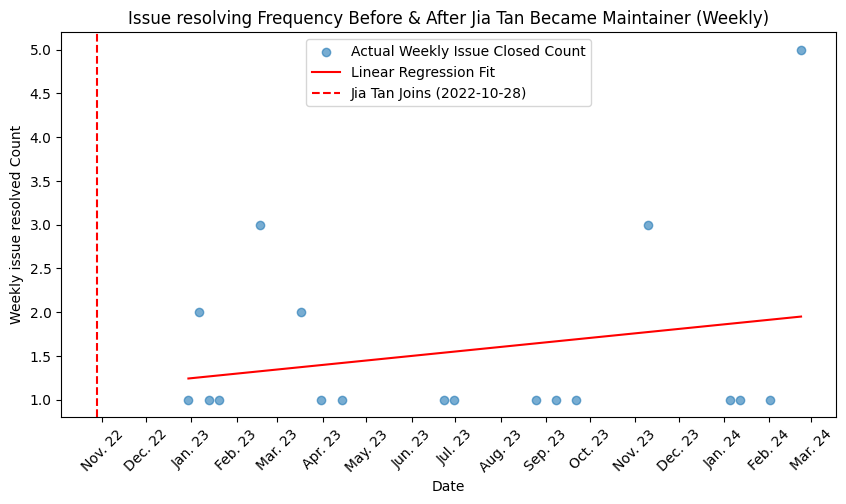

In [39]:
weekly_issues_closed["date"] = cutoff_date + pd.to_timedelta(weekly_issues_closed["weeks_since_JT_joined"] * 7, unit="D")

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(weekly_issues_closed["date"], weekly_issues_closed["issue_closed_count"], alpha=0.6, label="Actual Weekly Issue Closed Count")
plt.plot(weekly_issues_closed["date"], weekly_issues_closed["predicted_issue_closed_count"], color="red", label="Linear Regression Fit")

# Formatting the x-axis labels for weekly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b. %y"))  # Format as "Oct-22"
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Cutoff marker for when Jia Tan joined
plt.axvline(x=cutoff_date, color='r', linestyle='--', label="Jia Tan Joins (2022-10-28)")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Weekly issue resolved Count")
plt.title("Issue resolving Frequency Before & After Jia Tan Became Maintainer (Weekly)")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.legend()
plt.show()


**RDD on Suspicious Files Commit Frequency**
- Forcing Variable: Time (Weekly since Jia Tan joined)
- Cutoff Date:      2022-10-28 (when Jia Tan got added to the Tukaani Organization)
- Treatment Group:  2022-10-28 to 2024-03-28
- Control Group:    2021-01-01 to 2022-10-27 (1.5 year before)
- Outcome Variable: Weekly commit frequency on chosen files

**RDD Expectation:**
- If commit frequency significantly increased after Jia Tan joined, it suggests a potential correlation.
- A discontinuity would indicate an effect.

In [40]:
def fetch_commit_history(repo_owner, repo_name, file_path, github_token):
    """
    Fetches commit history for a specific file in a GitHub repository.
    
    Parameters:
    
        repo_owner (str): GitHub username or organization name.
        repo_name (str): Repository name.
        file_path (str): Path to the file in the repository.
        github_token (str): GitHub personal access token for authentication.
        
    Returns:
        pd.DataFrame: DataFrame containing commit history.
    """
    url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/commits"
    params = {"path": file_path, "per_page": 100}  # Fetch commits for the file
    headers = {"Authorization": f"token {github_token}"}

    commit_data = []
    
    while url:
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            print("Error fetching data:", response.json())
            break
        commits = response.json()
        if not commits:
            break

        for commit in commits:
            commit_info = commit.get("commit", {})
            author_info = commit_info.get("author", {})
            committer_info = commit_info.get("committer", {})

            commit_data.append({
                "commit_hash": commit["sha"],
                "commit_date": committer_info.get("date", "Unknown"),
                "author_name": author_info.get("name", "Unknown"),
                "committer_name": committer_info.get("name", "Unknown"),
                "commit_message": commit_info.get("message", "Unknown")
            })
        
        # Pagination handling
        url = response.links.get("next", {}).get("url")

    # Convert to DataFrame
    commit_df = pd.DataFrame(commit_data)
    commit_df["commit_date"] = pd.to_datetime(commit_df["commit_date"])
    
    return commit_df

In [41]:
GITHUB_TOKEN = os.getenv("GITHUB_PERSONAL_ACCESS_TOKEN")
repo_owner = "tukaani-project"
repo_name = "xz"
configure_path = "configure.ac"  # Replace with the file path you want to investigate
cmakelist_path = "CMakeLists.txt"
backdoor_path = "tests/files"


# Fetch commit history for the specified file
configure_commit_df = fetch_commit_history(repo_owner, repo_name, configure_path, GITHUB_TOKEN)
cmakelist_commit_df = fetch_commit_history(repo_owner, repo_name, cmakelist_path, GITHUB_TOKEN)
backdoor_commit_df = fetch_commit_history(repo_owner, repo_name, backdoor_path, GITHUB_TOKEN)




In [ ]:


configure_commit_df["commit_date"] = pd.to_datetime(configure_commit_df["commit_date"].dt.date)
cmakelist_commit_df["commit_date"] = pd.to_datetime(cmakelist_commit_df["commit_date"].dt.date)
backdoor_commit_df["commit_date"] = pd.to_datetime(backdoor_commit_df["commit_date"].dt.date)

configure_commit_df = configure_commit_df[
    (configure_commit_df["commit_date"] >= control_start_date) & 
    (configure_commit_df["commit_date"] <= treatment_end_date)
]
cmakelist_commit_df = cmakelist_commit_df[
    (cmakelist_commit_df["commit_date"] >= control_start_date) & 
    (cmakelist_commit_df["commit_date"] <= treatment_end_date)
]
backdoor_commit_df = backdoor_commit_df[
    (backdoor_commit_df["commit_date"] >= control_start_date) & 
    (backdoor_commit_df["commit_date"] <= treatment_end_date)
]

configure_commit_df["weeks_since_JT_joined"] = (configure_commit_df["commit_date"] - cutoff_date) / pd.Timedelta(days=7)
configure_commit_df = configure_commit_df.dropna(subset=["weeks_since_JT_joined"])
configure_commit_df["weeks_since_JT_joined"] = configure_commit_df["weeks_since_JT_joined"].astype(int)
weekly_configure_commits = configure_commit_df.groupby("weeks_since_JT_joined").size().reset_index(name="commit_count")
weekly_configure_commits["treatment"] = (weekly_configure_commits["weeks_since_JT_joined"] >= 0).astype(int)

cmakelist_commit_df["weeks_since_JT_joined"] = (cmakelist_commit_df["commit_date"] - cutoff_date) / pd.Timedelta(days=7)
cmakelist_commit_df = cmakelist_commit_df.dropna(subset=["weeks_since_JT_joined"])
cmakelist_commit_df["weeks_since_JT_joined"] = cmakelist_commit_df["weeks_since_JT_joined"].astype(int)
weekly_cmakelist_commits = cmakelist_commit_df.groupby("weeks_since_JT_joined").size().reset_index(name="commit_count")
weekly_cmakelist_commits["treatment"] = (weekly_cmakelist_commits["weeks_since_JT_joined"] >= 0).astype(int)

backdoor_commit_df["weeks_since_JT_joined"] = (backdoor_commit_df["commit_date"] - cutoff_date) / pd.Timedelta(days=7)
backdoor_commit_df = backdoor_commit_df.dropna(subset=["weeks_since_JT_joined"])
backdoor_commit_df["weeks_since_JT_joined"] = backdoor_commit_df["weeks_since_JT_joined"].astype(int)
weekly_backdoor_commits = backdoor_commit_df.groupby("weeks_since_JT_joined").size().reset_index(name="commit_count")
weekly_backdoor_commits["treatment"] = (weekly_backdoor_commits["weeks_since_JT_joined"] >= 0).astype(int)

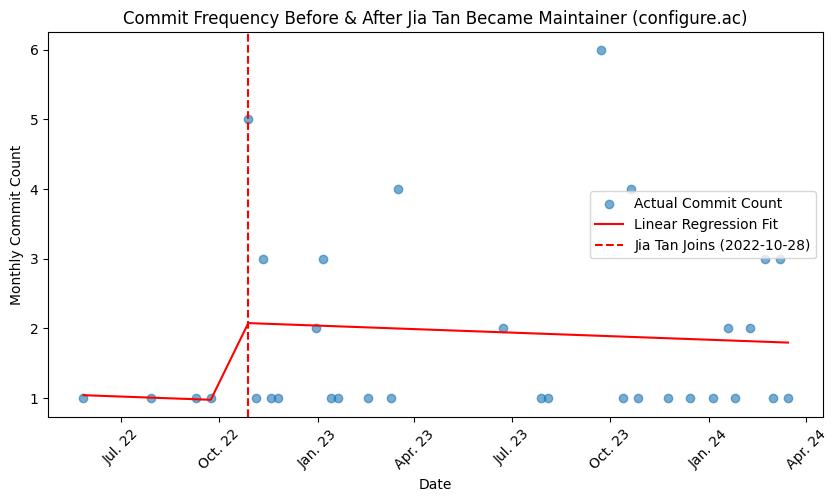

In [ ]:
# Linear regression model
X = weekly_configure_commits[["weeks_since_JT_joined", "treatment"]]
y = weekly_configure_commits["commit_count"]

linear_model = LinearRegression()
linear_model.fit(X, y)

# Predict commit count for visualization
weekly_configure_commits["predicted_commit_count"] = linear_model.predict(X)
weekly_configure_commits["date"] = cutoff_date + pd.to_timedelta(weekly_configure_commits["weeks_since_JT_joined"] * 7, unit="D")

# plot
plt.figure(figsize=(10, 5))
plt.scatter(weekly_configure_commits["date"], weekly_configure_commits["commit_count"], alpha=0.6, label="Actual Commit Count")
plt.plot(weekly_configure_commits["date"], weekly_configure_commits["predicted_commit_count"], color="red", label="Linear Regression Fit")

# Formatting the x-axis labels for monthly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b. %y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

# Cutoff marker for when Jia Tan joined
plt.axvline(x=cutoff_date, color='r', linestyle='--', label="Jia Tan Joins (2022-10-28)")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Monthly Commit Count")
plt.title("Commit Frequency Before & After Jia Tan Became Maintainer (configure.ac)")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.legend()
plt.show()



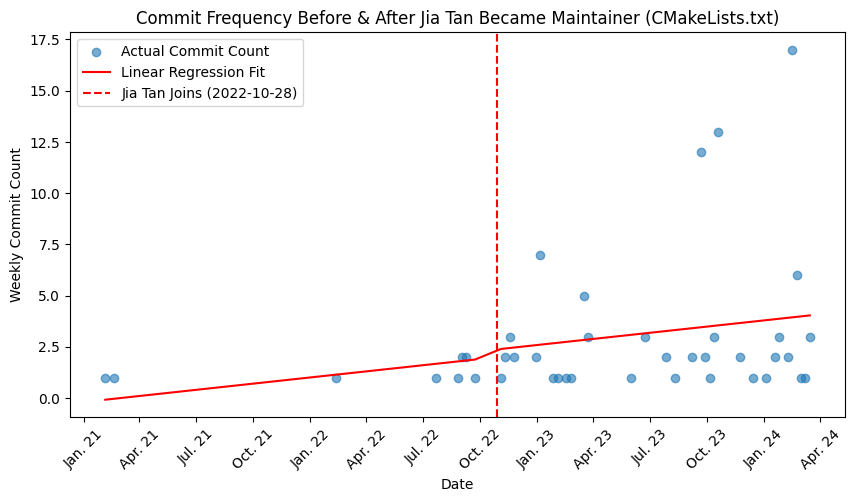

In [ ]:
X = weekly_cmakelist_commits[["weeks_since_JT_joined", "treatment"]]
y = weekly_cmakelist_commits["commit_count"]

linear_model = LinearRegression()
linear_model.fit(X, y)

weekly_cmakelist_commits["predicted_commit_count"] = linear_model.predict(X)
weekly_cmakelist_commits["date"] = cutoff_date + pd.to_timedelta(weekly_cmakelist_commits["weeks_since_JT_joined"] * 7, unit="D")

plt.figure(figsize=(10, 5))
plt.scatter(weekly_cmakelist_commits["date"], weekly_cmakelist_commits["commit_count"], alpha=0.6, label="Actual Commit Count")
plt.plot(weekly_cmakelist_commits["date"], weekly_cmakelist_commits["predicted_commit_count"], color="red", label="Linear Regression Fit")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b. %y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.axvline(x=cutoff_date, color='r', linestyle='--', label="Jia Tan Joins (2022-10-28)")

plt.xlabel("Date")
plt.ylabel("Weekly Commit Count")
plt.title("Commit Frequency Before & After Jia Tan Became Maintainer (CMakeLists.txt)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

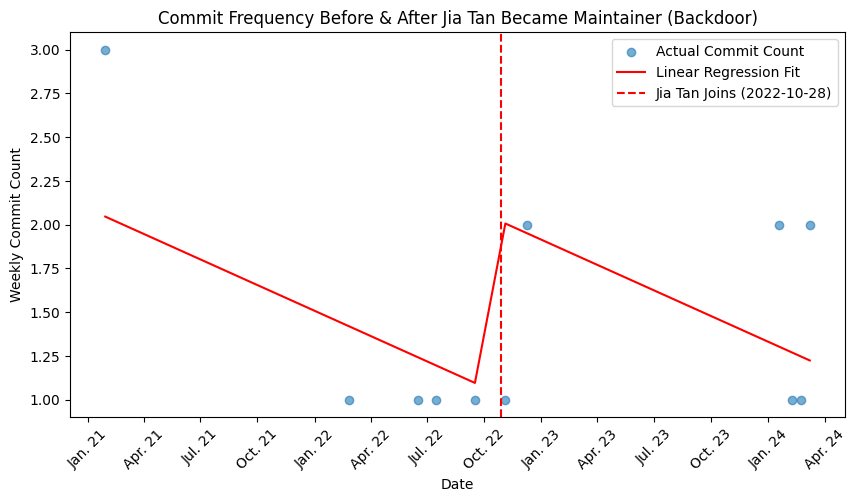

In [ ]:
X = weekly_backdoor_commits[["weeks_since_JT_joined", "treatment"]]
y = weekly_backdoor_commits["commit_count"]

linear_model = LinearRegression()
linear_model.fit(X, y)

weekly_backdoor_commits["predicted_commit_count"] = linear_model.predict(X)
weekly_backdoor_commits["date"] = cutoff_date + pd.to_timedelta(weekly_backdoor_commits["weeks_since_JT_joined"] * 7, unit="D")

plt.figure(figsize=(10, 5))
plt.scatter(weekly_backdoor_commits["date"], weekly_backdoor_commits["commit_count"], alpha=0.6, label="Actual Commit Count")
plt.plot(weekly_backdoor_commits["date"], weekly_backdoor_commits["predicted_commit_count"], color="red", label="Linear Regression Fit")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b. %y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.axvline(x=cutoff_date, color='r', linestyle='--', label="Jia Tan Joins (2022-10-28)")

plt.xlabel("Date")
plt.ylabel("Weekly Commit Count")
plt.title("Commit Frequency Before & After Jia Tan Became Maintainer (Backdoor)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [31]:

weekly_backdoor_commits = weekly_backdoor_commits.rename(columns={"commit_count": "frequency"})
weekly_cmakelist_commits = weekly_cmakelist_commits.rename(columns={"commit_count": "frequency"})
weekly_configure_commits = weekly_configure_commits.rename(columns={"commit_count": "frequency"})
weekly_commits = weekly_commits.rename(columns={"commit_count": "frequency"})
weekly_issues_closed = weekly_issues_closed.rename(columns={"issue_closed_count": "frequency"})
weekly_pr_closed = weekly_pr_closed.rename(columns={"pr_closed_count": "frequency"})


weekly_backdoor_commits["file"] = "sus_file_backdoor"
weekly_cmakelist_commits["file"] = "sus_file_CMakeLists"
weekly_configure_commits["file"] = "sus_file_configure"
weekly_commits["file"] = "weekly_commit_frequency"
weekly_issues_closed["file"] = "weekly_issue_closed"
weekly_pr_closed["file"] = "weekly_pr_closed"


common_columns = ["weeks_since_JT_joined", "frequency", "treatment", "file"]


weekly_backdoor_commits = weekly_backdoor_commits[common_columns]
weekly_cmakelist_commits = weekly_cmakelist_commits[common_columns]
weekly_configure_commits = weekly_configure_commits[common_columns]
weekly_commits = weekly_commits[common_columns]
weekly_issues_closed = weekly_issues_closed[common_columns]
weekly_pr_closed = weekly_pr_closed[common_columns]


combined_df = pd.concat([
    weekly_backdoor_commits, weekly_cmakelist_commits, weekly_configure_commits,
    weekly_commits, weekly_issues_closed, weekly_pr_closed
], ignore_index=True)




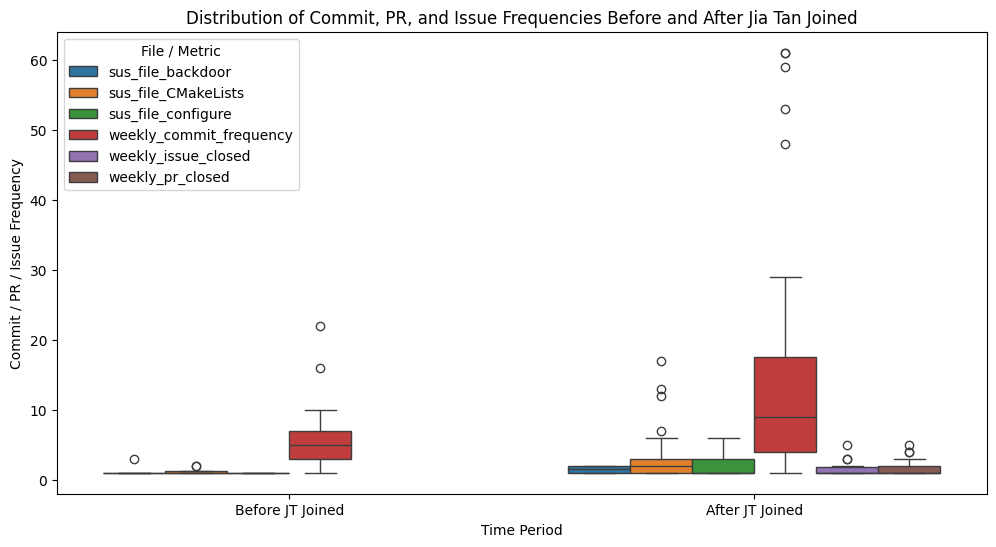

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="treatment", y="frequency", hue="file", data=combined_df)

# Customize labels
plt.xticks([0, 1], ["Before JT Joined", "After JT Joined"])
plt.xlabel("Time Period")
plt.ylabel("Commit / PR / Issue Frequency")
plt.title("Distribution of Commit, PR, and Issue Frequencies Before and After Jia Tan Joined")

plt.legend(title="File / Metric")
plt.show()